# Machine Learning 2024-2025 - UMONS

# Bias-variance tradeoff

**In this lab, we will experiment with the notorious 'Bias-Variance tradeoff', a highly important concept in machine learning. In the context of a regression task, you've seen in the course that there exists an elegant decomposition of the MSE, which allows to illustrate this concept nicely. Contrary to previous labs in which we worked with real datasets, we will place ourselves in a context where we know the true data generating process. This will enable us to estimate the bias and the variance of a given model.**

**We import the necessary libraries.**

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

np.random.seed(0)

### Data generating process

**1) Create the functions `fx` and `fy` that define the following data generating process:**

$$X \sim \mathcal{U}(-4, 4),$$

$$Y \sim f(X) + \epsilon,$$

**where $\mathcal{U}(a, b)$ denotes a uniform distribution between $a$ and $b$, $f(X) = \text{sin}(X) + X / 3$, and $\varepsilon \sim \mathcal{N}(0, 0.5^2)$ is a Gaussian noise with a normal distribution of mean 0 and standard deviation 0.5.**

**The parameter of `fx` should be:**
- **`size`, the size of the dataset which is sampled.**

**The parameters of `fy` should be:**
- **`x`: an array of conditioning values corresponding to the random variable $X$,**
- **`add_noise=True`: whether the noise $\epsilon$ should be added to $f(X)$ (true by default).**

In [3]:
def fx(size):
    return np.random.uniform(-4,4,size)

def fy(x,add_noise=True):
    return (np.sin(x) + x/3 + np.random.normal(0,(0.5)**2,x.size))if add_noise else np.sin(x) + x/3


**We define the size of the training dataset to `n_train = 30`.**

**We also define a set of values `x_test` on which we will evaluate the bias-variance tradeoff.**

In [4]:
n_train = 30
x_test = np.linspace(-4, 4, 100)

**We plot a training dataset sampled using the data generating process. We also plot the function $f(x)$.**

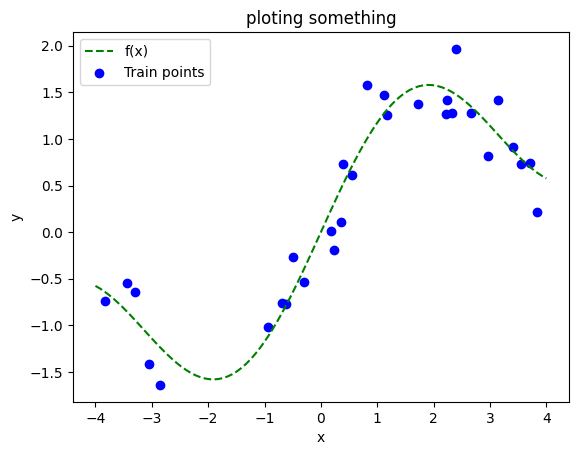

In [5]:
x_train = fx(n_train)
y_train = fy(x_train)
y_test = fy(x_test)
y_test_mean = fy(x_test, add_noise=False)

fig, ax = plt.subplots()
ax.plot(x_test, y_test_mean, label='f(x)', color='green', ls='--')
ax.scatter(x_train, y_train, label='Train points', color='blue')
ax.set(xlabel='x', ylabel='y')
ax.set_title("ploting something")
ax.legend()
plt.show()

### Linear regression model

**2) Our goal is to predict the values of $Y$ given the conditioning values $x_\text{test}$.**
- **Fit a linear regression model on the training dataset.**
- **Predict `y_pred` on the test dataset `(x_test, y_test)` and report the mean squared error (MSE).**
**Note that scikit-learn expects inputs of shape `(n_train, n_features)`, where the second dimension is 1 in our case since $X$ is unidimensional.**

In [7]:
# entrainer un model de regression sur le training set
model0 = LinearRegression(fit_intercept=True)
model0.fit(x_train.reshape(-1, 1), y_train)

# prediction sur le test set
y_pred = model0.predict(x_test.reshape(-1,1))
test_mse = mean_squared_error(y_pred , y_test)
print("MSE on test set = ",test_mse)

MSE on test set =  0.5089807956722124


**We draw the previous figure, with an added regression line corresponding to the predictions of the linear regression model on `x_test`. Does the model appear to be a good fit to the data? How do you link this observation to the bias-variance tradeoff?** 

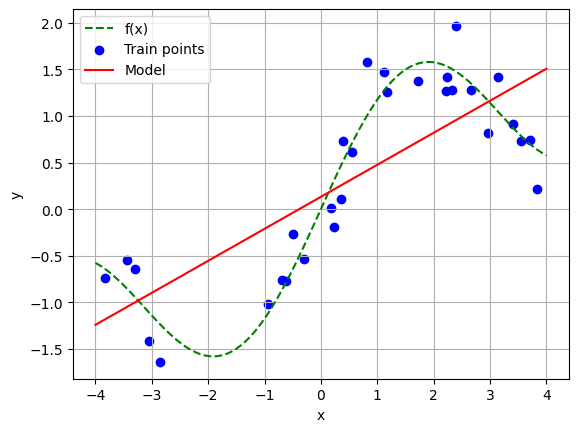

In [8]:
fig, ax = plt.subplots()
ax.plot(x_test, y_test_mean, label='f(x)', color='green', ls='--')
ax.scatter(x_train, y_train, label='Train points', color='blue')
ax.plot(x_test, y_pred, label='Model', color='red')
ax.set(xlabel='x', ylabel='y')
ax.legend()
ax.grid(True)
plt.show()

**3) We will now decompose our models' test MSE into a bias, variance, and Bayes error term. Recall from the course that the MSE decomposition is given by:**

$$\mathbb{E}_{\mathcal{D},y,x}[(y-g(x))^2)] = \underbrace{\mathbb{E}_x[\text{Var}(y|x)]}_{\text{Bayes Error}} + \underbrace{\mathbb{E}_x[(f(x)-\mathbb{E}_\mathcal{D}[g(x)])^2]}_{\text{Bias}} + \underbrace{\mathbb{E}_x[\text{Var}_\mathcal{D}(g(x))]}_{\text{Variance}},$$

**where $\mathcal{D}$ is a training set from the data generating process.**

**To estimate each term of the decomposition, we will:**
- **Fix a set of features $\{x_i^\text{test}\}_{i=1}^{n_\text{test}}$ on which we will evaluate the bias-variance tradeoff.**
- **For $j=1,\dots,J$, we will simulate the modeling pipeline:**
    - **Sample a dataset $\mathcal{D}_{j,\text{train}}$ containing $n_\text{train}$ observations $\{(x_{i,j}^\text{train}, y_{i,j}^\text{train})\}_{i=1}^{n_\text{train}}$.**
    - **Fit the model to $\mathcal{D}_{j,\text{train}}$, yielding $g_j$.**
    - **Sample a dataset $\mathcal{D}_{j,\text{test}}$ containing $n_\text{test}$ observations $\{(x_{i}^\text{test}, y_{i,j}^\text{test})\}_{i=1}^{n_\text{test}}$.**
    - **Make predictions on $\mathcal{D}_{j,\text{test}}$ using $g_j$.**

**The above steps will allow us to obtain an estimate of the bias and variance of the fitted models:**
$$\mathbb{E}_{\mathcal{D},y,x}[(y-g(x))^2)] \simeq \underbrace{\frac{1}{n_{\text{test}}} \sum_{i=1}^{n_\text{test}} \Big[\frac{1}{J} \sum_{j=1}^J (y^\text{test}_{i,j} - \bar{y_i})^2\Big]}_{\text{Bayes Error}} + \underbrace{\frac{1}{n_{\text{test}}} \sum_{i=1}^{n_\text{test}} \Big[(f(x_i^\text{test}) - \bar{g}(x_i^\text{test}))^2\Big] }_{\text{Squared bias}} + \underbrace{\frac{1}{n_{\text{test}}} \sum_{i=1}^{n_{\text{test}}} \Big[\frac{1}{J}\sum_{j=1}^J(g_j(x_i^\text{test}) - \bar{g}(x_i^\text{test}))^2 \Big]}_{\text{Variance}},$$

**where $\bar{y}_i = \frac{1}{J} \sum_{j=1}^J y_{i,j}^\text{test}$ and $\bar{g}(x_i^\text{test}) = \frac{1}{J}\sum_{j=1}^J g_j(x_i^\text{test})$.**

**To this end, complete the functions `simulate_modeling_pipeline` and `bias_variance_estimator` below. The parameters are:**
- `model`: the scikit-learn model.
- `x_test`: the array of features $\{x_i^\text{test}\}_{i=1}^{n_\text{test}}$.
- `n_train`, `fx`, and `fy`: they define the data generating process of $\mathcal{D}_{j,\text{test}} = \{(x_{i,j}^\text{train}, y_{i,j}^\text{train})\}_{i=1}^{n_\text{train}}$.
- `n_datasets`: the number $J$ of datasets to generate.

In [ ]:
def simulate_modeling_pipeline(model, x_test, n_train, fx, fy):
    # The training dataset is generated using `fx` and `fy`
    x_train = fx(n_train)
    y_train = fy(x_train)
    # The test target is generated using `fy` and the provided `x_test`
    y_test = fy(x_test)
    # The model is trained on the training dataset and used to predict the test target `y_pred`
    m = model.fit(x_train,y_train)
    y_pred = m.predict(x_test)
    return y_test, y_pred


def bias_variance_estimator(model, x_test, n_train, fx, fy, n_datasets):
    y_test, y_pred = [], []
    # We simulate the modeling pipeline on `n_datasets` datasets
    for _ in range(n_datasets):
        y_test_i, y_pred_i = simulate_modeling_pipeline(model, x_test, n_train, fx, fy)
        y_test.append(y_test_i)
        y_pred.append(y_pred_i)

    # We get targets and predictions as numpy arrays of shape (n_datasets, n_test)
    y_test = np.array(y_test)
    y_pred = np.array(y_pred)

    # We compute the MSE, bias, variance and Bayes error of each test point
    # Each of these quantities must be an array of shape (n_test,)
    # The suffix _x indicates that the estimation is conditional on x
    mse_x = 0
    bayes_error_x = 0
    bias_x = 0
    variance_x = 0
    return mse_x, bayes_error_x, bias_x, variance_x

**4) Call `bias_variance_estimator` and verify that the decomposition $\text{MSE} = \text{Bayes Error} + \text{Squared Bias} + \text{Variance}$ is approximately correct when $J$ is sufficiently large. Does the value obtained for the Bayes Error make sense?**

**5) Based on the results of `bias_variance_estimator`, plot the MSE, Bayes error, bias, and variance conditionally on $X$, for each $x$ in `x_test`. How do you interpret the plot?**

### Polynomial regression model

**We will now study how the bias and variance of a model evolve when varying its complexity. To this end, we will use polynomial regression models with varying degrees. Examples of predictions are given below.**

In [11]:
def PolynomialRegression(degree, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), LinearRegression(**kwargs))

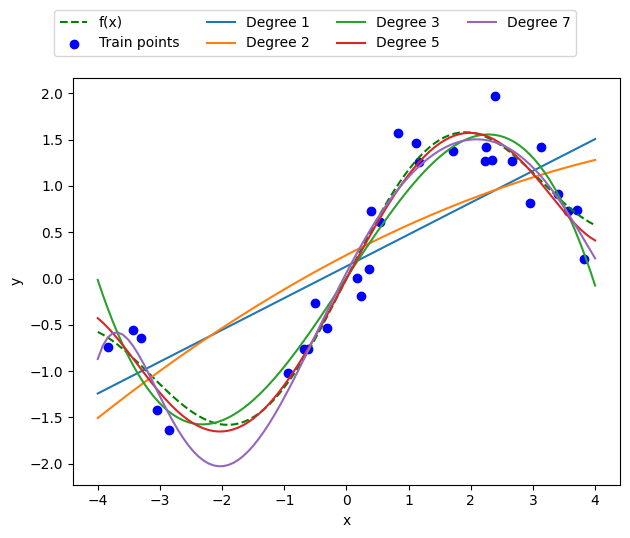

In [12]:
# We fit models of varying degrees on the training dataset
models = []
degrees = [1, 2, 3, 5, 7]
for degree in degrees:
    model = PolynomialRegression(degree, fit_intercept=True)
    model.fit(x_train[:, np.newaxis], y_train)
    models.append(model)
# We plot the predictions of the models
fig, ax = plt.subplots()
ax.plot(x_test, y_test_mean, label='f(x)', color='green', ls='--')
ax.scatter(x_train, y_train, label='Train points', color='blue')
for model in models:
    degree = model.get_params()['polynomialfeatures__degree']
    y_pred = model.predict(x_test[:, np.newaxis])
    ax.plot(x_test, y_pred, label=f'Degree {degree}')
ax.set(xlabel='x', ylabel='y')
fig.legend(loc='lower center', bbox_to_anchor=(0.5, 1), frameon=True, ncol=4)
fig.tight_layout()

**6) For polynomial regression models with degrees ranging from 1 to 6, can you collect the MSE, Bayes error, bias, and variance, and plot them as a function of the degree? What do you observe?**

### $K$-nearest neighbors regression model

**Finally, we investigate another class of models, $K$-nearest neighbors regression models.**

**Given a feature $x$, these models select the $K$ points $\{(x_k, y_k)\}_{k=1}^K$ whose features are closest to $x$ and predict the average target among these $K$ points. Examples of predictions are given below.**

In [ ]:
models = []
n_neighbors_list = [1, 3, 10]
for n_neighbors_list in n_neighbors_list:
    model = KNeighborsRegressor(n_neighbors=n_neighbors_list)
    model.fit(x_train[:, np.newaxis], y_train)
    models.append(model)

fig, ax = plt.subplots()
ax.plot(x_test, y_test_mean, label='f(x)', color='green', ls='--')
ax.scatter(x_train, y_train, label='Train points', color='blue')

for model in models:
    K = model.get_params()['n_neighbors']
    y_pred = model.predict(x_test[:, np.newaxis])
    ax.plot(x_test, y_pred, label=f'{K}-neighbors')

ax.set(xlabel='x', ylabel='y')
fig.legend(loc='lower center', bbox_to_anchor=(0.5, 1), frameon=True, ncol=4)
fig.tight_layout()

**7) Repeat the same exercise as in 6), but for the number of neighbors in a `KNeighborsRegressor`.**

**Are the evolution of the bias, variance, and Bayes error term expected?**

### Optional experiments

**Based on the code above, can you answer the following questions?**
- **How does the bias-variance tradeoff change when varying the number of training samples?**
- **How does the bias-variance tradeoff change with a more complex data generating process?**
- **Can you plot the MSE, Bayes error, bias, and variance as a function of $x$ for different polynomials and $K$-nearest neighbors regression models? How do you interpret them?**